<a href="https://colab.research.google.com/github/nirjar018/Image-Segmentation/blob/main/SMP_ResNeXt101_32x8d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install mlflow
!pip install pytorch-lightning
!pip install --upgrade pytorch-lightning
!pip install pyngrok

In [2]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-y5xvq__g
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-y5xvq__g
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit bd7f877fec51309a1a7de7670aed232954450037
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nirjarpatel","key":"a24c399e83b88217a912c80c4d3a07f7"}'}

In [4]:
import os
import zipfile

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d intelecai/car-segmentation

# Unzip the downloaded dataset
!unzip car-segmentation.zip -d /kaggle/car-segmentation

Dataset URL: https://www.kaggle.com/datasets/intelecai/car-segmentation
License(s): other
car-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  car-segmentation.zip
replace /kaggle/car-segmentation/car-segmentation/classes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /kaggle/car-segmentation/car-segmentation/images/003.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: aA
error:  invalid response [aA]
replace /kaggle/car-segmentation/car-segmentation/images/003.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /kaggle/car-segmentation/car-segmentation/images/003.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618339-super-purple-modern-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618639-modern-pale-blue-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/156551_preview.png  
  inflating: /kaggle/car-segmentation/car-seg

In [6]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from tqdm import tqdm
import torchmetrics
import mlflow
import mlflow.pytorch
import subprocess
from pyngrok import ngrok,conf
import getpass
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [7]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db"])

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("SMP_Resnet34")

<Experiment: artifact_location='/content/mlruns/1', creation_time=1720636253299, experiment_id='1', last_update_time=1720636253299, lifecycle_stage='active', name='SMP_Resnet34', tags={}>

In [8]:
print("Enter your authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken
··········
 * ngrok tunnel "https://95d1-34-87-185-171.ngrok-free.app" -> "http://127.0.0.1:5000"


In [9]:
ROOT_DIR =  '/kaggle/car-segmentation/car-segmentation'

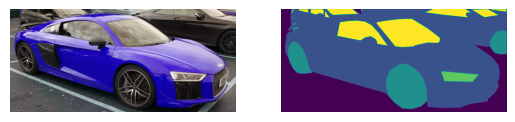

In [10]:
img = cv2.imread(f"{ROOT_DIR}/images/audi-r8-v10-car-side-view.png")
mask = cv2.imread(f"{ROOT_DIR}//masks/audi-r8-v10-car-side-view.png")
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])
plt.axis(False)
plt.show()

In [11]:
class CarData(Dataset):
    def __init__(self,image_dir , mask_dir, transform=None):
      super().__init__()
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.image_list = sorted(os.listdir(self.image_dir))
      self.mask_list = sorted(os.listdir(self.mask_dir))
      self.transform = transform

    def __getitem__(self,index):
        img = cv2.imread(self.image_dir+self.image_list[index])
        mask = cv2.imread(self.mask_dir+self.mask_list[index])[:,:,0]
        img = cv2.resize(img, (256, 256))  # Resize image to 256x256
        mask = cv2.resize(mask, (256, 256))  # Resize mask to 256x256
        if self.transform:
            augmented = self.transform(image=np.array(img), mask=np.array(mask))
            img = augmented['image']
            mask = augmented['mask']
        img = img.transpose(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)
        img = torch.tensor(img, dtype=torch.float32)
        return img, mask

    def __len__(self):
      return len(self.image_list)


t_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=35,p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

v_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

car_data = CarData(f"{ROOT_DIR}/images/",f"{ROOT_DIR}/masks/", transform=None)
train_size = int(0.8 * len(car_data))
val_size = len(car_data) - train_size
train_data, val_data = random_split(car_data, [train_size, val_size])

train_data.transform = t_transform
val_data.transform = v_transform

train_dataloader = DataLoader(train_data,batch_size=2,shuffle=True)
val_dataloader = DataLoader(val_data,batch_size=2,shuffle=False)


In [12]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import Callback
class MLflowLoggingCallback(Callback):
    def on_epoch_end(self, trainer, pl_module):
        # Get the training and validation losses from the callback metrics
        train_loss = trainer.callback_metrics.get('train_loss')
        val_loss = trainer.callback_metrics.get('val_loss')

        # Log the metrics to MLflow
        if train_loss is not None:
            mlflow.log_metric('train_loss', train_loss.item(), step=trainer.current_epoch)
        if val_loss is not None:
            mlflow.log_metric('val_loss', val_loss.item(), step=trainer.current_epoch)


In [22]:
class SMP(pl.LightningModule):
    def __init__(self, lr=0.001):
        super(SMP, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnext101_32x8d",
            encoder_depth=5,
            encoder_weights="imagenet",
            in_channels=3,
            classes=5
        )
        self.lr=lr
        self.criterion = nn.CrossEntropyLoss()
        self.metric = torchmetrics.Dice(num_classes=5, average='macro')

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
       return optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, masks)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, masks)
        outputs = torch.argmax(outputs, dim=1)
        score = self.metric(outputs, masks)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_dice', score, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': loss, 'val_dice': score}

In [23]:
mlflow_logger = MLFlowLogger(experiment_name='SMP_ResNext101', tracking_uri=public_url)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:05<00:00, 68.9MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Unet             | 95.8 M | train
1 | criterion | CrossEntropyLoss | 0      | train
2 | metric    | Dice             | 0      | train
-------------------------------------------------------
95.8 M    Trainable params
0         Non-trainable params
95.8 M    Total params
383.024   Total estimated model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
2024/07/10 21:03:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


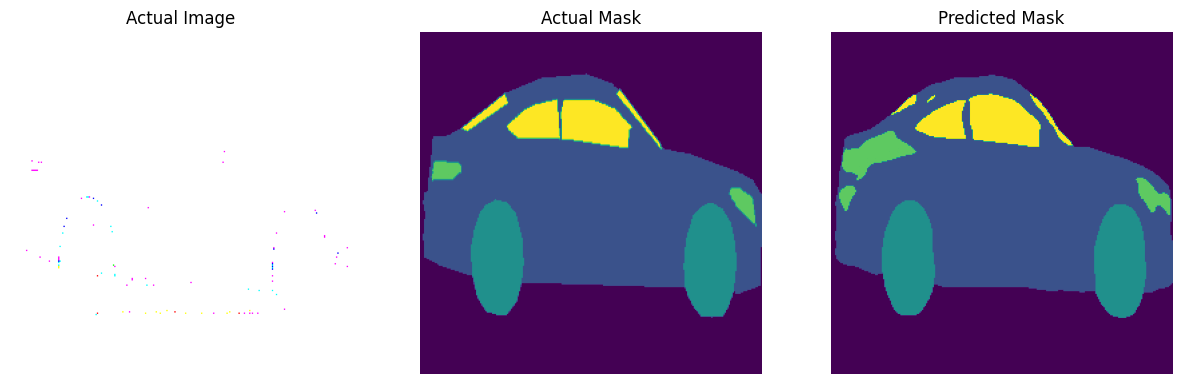

Average Dice Score: 0.818047046661377


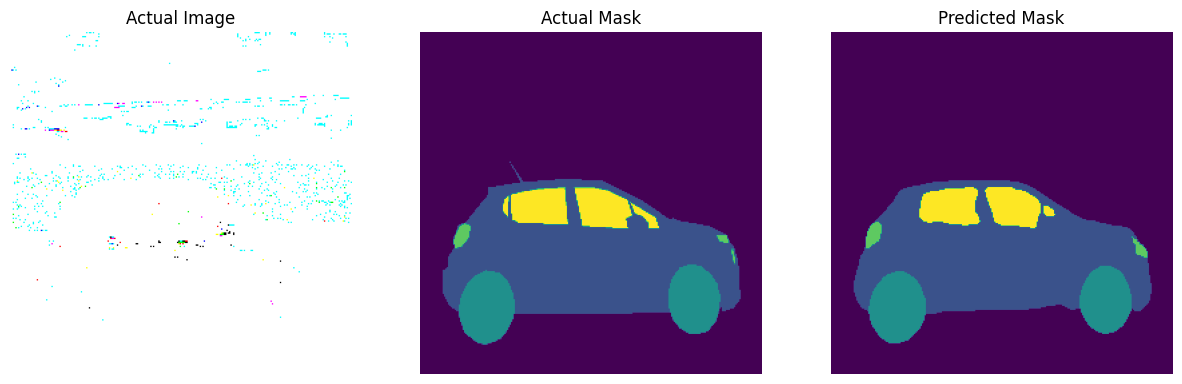

Average Dice Score: 0.8566451370716095


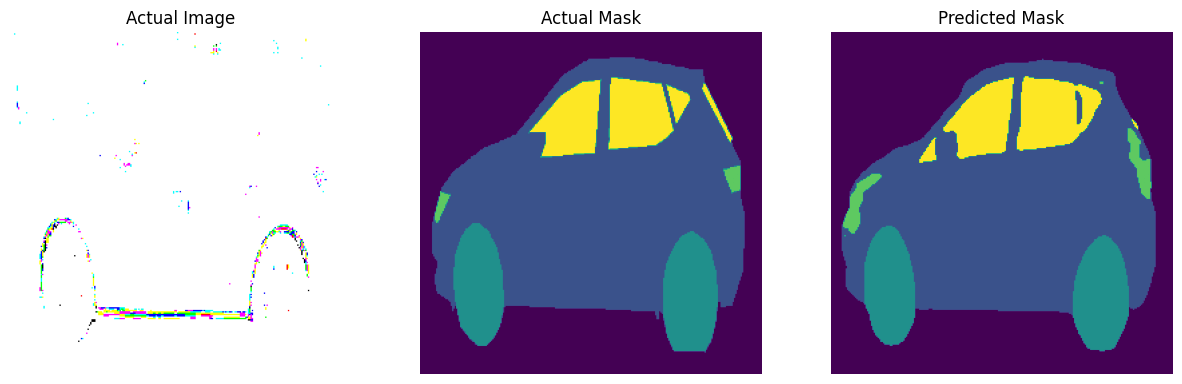

Average Dice Score: 0.8560224374135336


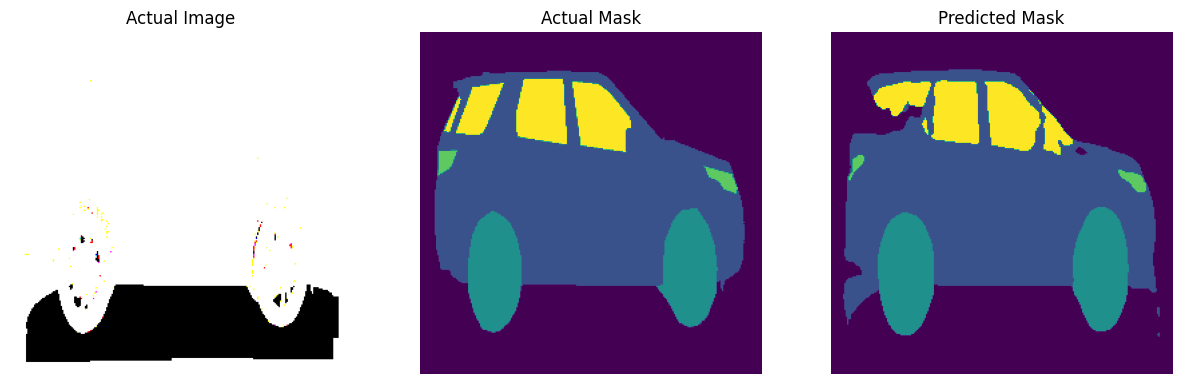

Average Dice Score: 0.8613187372684479


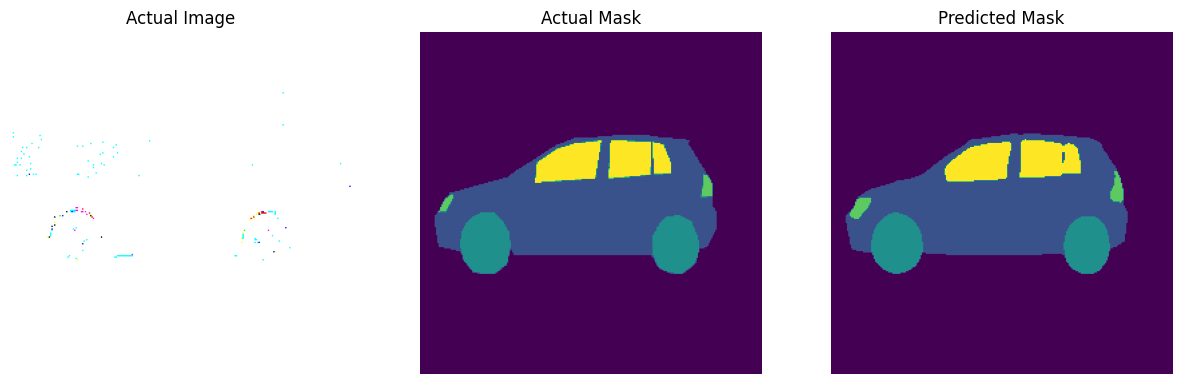

Average Dice Score: 0.8669284582138062


In [24]:
model = SMP(lr=0.001)

with mlflow.start_run():
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1 if torch.cuda.is_available() else 1,
        logger=mlflow_logger,
        callbacks=[MLflowLoggingCallback()]
    )
    trainer.fit(model, train_dataloader, val_dataloader)

    mlflow.pytorch.log_model(model, "model")

    # mlflow.log_param("img_size", img_size)
    mlflow.log_param("batch_size", 2)
    mlflow.log_param("max_epochs", 50)

    model.eval()
    test_data, _ = random_split(val_data, [5, len(val_data)-5])
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

    def predictions(images, masks, outputs, idx):
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        ax[0].imshow(images.cpu().permute(1,2,0))
        ax[0].set_title('Actual Image')
        ax[1].imshow(masks.cpu())
        ax[1].set_title('Actual Mask')
        ax[2].imshow(outputs.cpu())
        ax[2].set_title('Predicted Mask')
        for a in ax:
            a.axis('off')
        plt.savefig(f'prediction_{idx}.png')
        plt.show()
        mlflow.log_artifact(f'prediction_{idx}.png')

    dice_scores = []
    for idx, (images,masks) in enumerate(test_loader):
        images = images.to(model.device)
        masks = masks.to(model.device)

        with torch.no_grad():
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)
            dice_score = torchmetrics.functional.dice(outputs, masks, num_classes=5, average='macro')
            dice_scores.append(dice_score.item())
            predictions(images[0], masks[0], outputs[0], idx)

        avg_dice_score = np.mean(dice_scores)
        mlflow.log_metric("average_dice_score", avg_dice_score)
        print(f'Average Dice Score: {avg_dice_score}')